# The classification task

This is where all things come together, where the actual classification task is carried out.

In [1]:
# define a logger
import logging
logging.getLogger().setLevel(logging.INFO)

### Early stopping

A class that allows interruption of a NN's training process 

In [2]:
class EarlyStopping(object):
    def __init__(self, patience=100):
        self.patience = patience
        self.best_valid = np.inf
        self.best_valid_epoch = 0
        self.best_weights = None

    def __call__(self, nn, train_history):
        current_valid = train_history[-1]['valid_loss']
        current_epoch = train_history[-1]['epoch']
        if current_valid < self.best_valid:
            self.best_valid = current_valid
            self.best_valid_epoch = current_epoch
            self.best_weights = nn.get_all_params_values()
        elif self.best_valid_epoch + self.patience < current_epoch:
            print("Early stopping.")
            print("Best valid loss was {:.6f} at epoch {}.".format(
                self.best_valid, self.best_valid_epoch))
            nn.load_params_from(self.best_weights)
            raise StopIteration()

### Read model from disk

Assumes files are in a subdir called `cache`. Conventions for the files is `allDocs<DIM>D.model`, where `DIM` is
the dimensionality of the embedding. `DIM` is determined by the parameter `dim`. 600 is the default dimensionality.

In [3]:
# Read model from disk
from gensim.models import Doc2Vec
import os

def loadModel(dim=600):
    if(dim not in (100, 300, 600)):
        raise ValueError('dim must be 100, 300 or 600')
        
    modelName = 'allDocs' + str(dim) + 'D.model'
    modelBasePath = 'cache'
    modelPath = os.path.join(os.getcwd(), modelBasePath, modelName)

    logging.info('start loading the model')
    model = Doc2Vec.load(modelPath)
    logging.info('loading completed')
    return model

INFO:gensim.utils:Pattern library is not installed, lemmatization won't be available.
INFO:summa.preprocessing.cleaner:'pattern' package not found; tag filters are not available for English


### Compile corpus

Returns corpus prepared in a way appropriate for gensim/scipy models to fit to. 
The first element of the tuple returned is a matrix of numpy integers representing the doc embedding.
The second elements indicates whether a document was cited at all. If `regression` is set to `True` it will be represented by either `[0,1]` (was not cited) or `[1,0]` (was cited). Otherwise it is `0` and `1`. 

In [4]:
import os
import json
from tqdm import tqdm
import numpy as np

'''
The try-except blocks take care of initializing the variables appropriately.
If they are non-existing, they are being initialized with the empty dict.
If they exist, they remain untouched. The reason for this is, that they may contain data
that was read from disk, which takes a while. 
The variables ought to contain either the large objects just described of the empty dict.
This is convenient when itegation over the data several times.
'''
try:
    model
except NameError:
    model = {}

try:
    X
    y
except NameError:
    X, y = {}, {}

def loadData(model=None, regression=False):
    JSONFILESDIR = 'data/json'
    X = []
    y = []
    
    if regression:
        zero = np.array([0,1], dtype=np.int32)
        one = np.array([1,0], dtype=np.int32)
    else:
        zero = np.int32(0)
        one = np.int32(1)

    logging.info('building corpus...')
    filenames = model.docvecs.doctags.keys()
    for k in tqdm(filenames):
        with open(os.path.join(JSONFILESDIR, k + '.json')) as fh:
            jsonFile = json.load(fh)

        if jsonFile['lang'] != 'en' or jsonFile['citedBy'] is None:
            logging.debug('{f} discarded from corpus.'.format(f=k))
            continue

        X.append(model.docvecs[k])
        isSuccessfull = one if int(jsonFile['citedBy']) > 0 else zero
        y.append(isSuccessfull)
        logging.debug('{f} absorbed into corpus.'.format(f=k))

    # transform to numpy arrays
    X = np.array(X)
    y = np.array(y)

    logging.info('corpus complete')
    return X, y

# This wrapper prevents the data from being loaded again, in case they are
# already in place
def loadXy(inputDim = 600, regression=False):
    # get the persisted model, including the training
    # data associated with it. check if already loaded
    global model
    global X, y
    # if currently loaded data doesn't match the requested dimensionality
    if type(X) == np.ndarray and X.shape[1] != inputDim:
        model, X, y = {}, {}, {}
    if model == {}:
        model = loadModel(inputDim)
    
    # give the data in a convenient format
    if any([type(X) != np.ndarray, type(y) != np.ndarray]):
        X, y = loadData(model=model, regression=regression)
    return X, y

### Neuronal network factory

`loadNN` return neuronal networks in the configuration that is passed to it.

In a OOP environment `makeLayers` and `makeParameters` were private methods, only used internally. Here, only `loadNN` needs to use them. They are not supposed to be used by users.

In [5]:
# classifying neural net
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet
from lasagne.nonlinearities import rectify, tanh, softmax, sigmoid

def makeLayers(depth=3):
    yield ('input', layers.InputLayer)
    yield ('hidden0', layers.DenseLayer)
    for i in range(1, depth - 2):
        yield ('dropout' + str(i-1), layers.DropoutLayer)
        yield ('hidden' + str(i), layers.DenseLayer)
    yield ('output', layers.DenseLayer)
    
def makeParameters(arch, dropout_p, nonlinearity):
    if len(arch) < 3:
        raise ValueError("The network must be at least 3 layers deep")
    depth = len(arch)
    params = {}
    
    # the static ones
    exec('params["{}"] = ({}, {})'.format('input_shape', "None", arch[0]))
    exec('params["{}"] = {}'.format('hidden0_num_units', arch[1]))
    for i in range(1, depth - 2):
        exec('params["{}"] = {}'.format('dropout' + str(i-1) + '_p', dropout_p))
        exec('params["{}"] = {}'.format('hidden' + str(i) + '_num_units', arch[i+1]))
    
    # again some statics ones
    exec('params["{}"] = {}'.format('output_num_units', arch[-1]))
    exec('params["{}"] = {}'.format('output_nonlinearity', nonlinearity))
    return params

def loadNN(arch=(100, 400, 160, 2), dropout_p=0.6, epochs=50,\
           nonlinearity=None, regression=False, evalSize=.1):
    if not regression and nonlinearity != 'softmax':
        nonlinearity = 'softmax'
        logging.info("nonlinearity was set to 'softmax'. This is\
            the only non-linearity supported by classification")
        
    return NeuralNet(
        # configuration
        layers=[x for x in makeLayers(len(arch))],
        **makeParameters(arch, dropout_p, nonlinearity),
        
        # optimization method:
        update=nesterov_momentum,
        update_learning_rate=0.01,
        update_momentum=0.9,

        regression=regression,
        max_epochs=epochs,
        eval_size=evalSize,
        verbose=1,
        on_epoch_finished=[EarlyStopping(patience=10)]
        )

/home/user/projekte/anaconda3/envs/ipynb/lib/python3.5/site-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


### Generate Classifier and fit them to the data

In [6]:
from sklearn.cross_validation import train_test_split
from collections import namedtuple
import numpy as np
from sklearn import svm
from sklearn.neighbors.nearest_centroid import NearestCentroid

TrainTestData = namedtuple("TrainTest", ["X_train","X_test","y_train","y_test"])


# Generate an SVM classifier
def genSVMclf(inputDim=600, evalSize=.1):
    clf = svm.SVC()
    X, y = loadXy(inputDim=inputDim, regression=False)
    # carry out train/test split
    X_train, X_test, y_train, y_test = train_test_split( \
        X, y, test_size=evalSize, random_state=42)
    clf.fit(X_train, y_train)
    return clf, TrainTestData(X_train, X_test, y_train, y_test)

# Generate an KNN classifier
def genKNNclf(inputDim, evalSize=.1):
    clf = NearestCentroid()
    X, y = loadXy(inputDim=inputDim, regression=False)
    # carry out train/test split
    X_train, X_test, y_train, y_test = train_test_split( \
        X, y, test_size=evalSize, random_state=42)
    clf.fit(X_train, y_train)
    return clf, TrainTestData(X_train, X_test, y_train, y_test)

# Generate an NN classifier
def genNNclf(inputDim=600, regression=False, arch=(400, 160, 2), \
            dropout_p=.6, epochs=100, nonlinearity='softmax', \
            evalSize=.1):

    X, y = loadXy(inputDim=inputDim, regression=regression)
    # add input layer to NN's arch
    myArch = list(arch)
    myArch.insert(0, inputDim)
    
    # instanciate the network
    net = loadNN(arch=myArch, dropout_p=dropout_p, epochs=epochs, \
                 nonlinearity=nonlinearity, regression=regression,
                 evalSize=evalSize)
    # carry out train/test split
    X_train, X_test, y_train, y_test = train_test_split( \
        X, y, test_size=evalSize, random_state=42)
    
    # train the network
    net.fit(X_train, y_train)
    
    return net, TrainTestData(X_train, X_test, y_train, y_test)

In [7]:
NNCandidate = namedtuple('NNCandidate', \
                         ['inputDim', 'dropout', 'arch', 'evalRes'])
EvalResults = namedtuple('EvalResults', ['All','Pos','Neg', 'SuccRate', 
                         'TrainLoss', 'ValidLoss'])
NNcandidatesPath = os.path.join('cache', 'NNcandidates')

### Evaluate the results

Evaluates the performance of a classifier (requires the `predict` method) using test data.

In [8]:
from collections import namedtuple
from nolearn.lasagne import NeuralNet

def evalPrediction(clf, trainTestData, regression=False):
    # predict the test set
    predictions = clf.predict(trainTestData.X_test)
    predictions = predictions.round().astype(np.int32)
    
    # dealing with the different data representations 
    # of regression vs classification
    if regression:
        truthMatrix = trainTestData.y_test[:, 0] == predictions[:, 0]
        positiveTestCases = trainTestData.y_test[:, 0].sum()
    else:
        truthMatrix = trainTestData.y_test == predictions
        positiveTestCases = trainTestData.y_test.sum()

    testSize = truthMatrix.shape[0]
    correct = truthMatrix.sum()
    false = testSize - truthMatrix.sum()
    if isinstance(clf, NeuralNet):
        train_loss = np.array([i["train_loss"] for i in net.train_history_])
        valid_loss = np.array([i["valid_loss"] for i in net.train_history_])
    else:
        train_loss = ""
        valid_loss = ""
    
    return EvalResults(testSize, correct, false, correct/float(testSize),\
                       train_loss, valid_loss)

### Automatic Hyperspace parameter evaluation

Findes the best performing parameters for the NN classifier using brute-force and pickles the results for later inspection. 

In [9]:
# automated nn testing
from collections import namedtuple
import pickle
import os

# predefined network architectures
archs = ((100, 2), (300, 2), (250, 80, 2), (500, 160, 2), (400, 150, 40, 2))

for inputDim in (100, 300, 600):
    for dropout in (.4, .6):
        for arch in archs:
            net, trainTestData = genNNclf(inputDim=inputDim, arch=arch, dropout_p=dropout, regression=True)
            evalRes = evalPrediction(net, trainTestData)
            candidate = NNCandidate(inputDim, dropout, arch, evalRes)
            with open(os.path.join(NNcandidatesPath, str(inputDim) + str(dropout) + str(arch) + '.pickle'), 'wb') as fh:
                pickle.dump(candidate, fh)

INFO:root:start loading the model
INFO:gensim.utils:loading Doc2Vec object from /home/user/projekte/econstorModelling/cache/allDocs100D.model
INFO:gensim.utils:loading docvecs recursively from /home/user/projekte/econstorModelling/cache/allDocs100D.model.docvecs.* with mmap=None
INFO:gensim.utils:loading syn0 from /home/user/projekte/econstorModelling/cache/allDocs100D.model.syn0.npy with mmap=None
INFO:gensim.utils:loading syn1 from /home/user/projekte/econstorModelling/cache/allDocs100D.model.syn1.npy with mmap=None
INFO:gensim.utils:setting ignored attribute syn0norm to None
INFO:gensim.utils:setting ignored attribute cum_table to None
INFO:root:loading completed
INFO:root:building corpus...
INFO:root:corpus complete


# Neural Network with 10302 learnable parameters

## Layer information

  #  name       size
---  -------  ------
  0  input       100
  1  hidden0     100
  2  output        2

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.23686       0.22693      1.04375  0.30s
      2       0.22369       0.22040      1.01491  0.22s
      3       0.21963       0.21772      1.00877  0.25s
      4       0.21771       0.21650      1.00559  0.25s
      5       0.21658       0.21581      1.00357  0.23s
      6       0.21576       0.21532      1.00204  0.22s
      7       0.21507       0.21493      1.00066  0.26s
      8       0.21444       0.21460      0.99925  0.22s
      9       0.21385       0.21434      0.99768  0.21s
     10       0.21327       0.21408      0.99623  0.22s
     11       0.21270       0.21382      0.99477  0.21s
     12       0.21214       0.21358      0.99328  0.21s
     13       0.21158       0.21336     

/home/user/projekte/anaconda3/envs/ipynb/lib/python3.5/site-packages/nolearn/lasagne/base.py:250: UserWarning: The 'eval_size' argument has been deprecated, please use the 'train_split' parameter instead, e.g.
train_split=TrainSplit(eval_size=0.4)
  warn("The 'eval_size' argument has been deprecated, please use "
/home/user/projekte/anaconda3/envs/ipynb/lib/python3.5/site-packages/nolearn/lasagne/base.py:250: UserWarning: The 'eval_size' argument has been deprecated, please use the 'train_split' parameter instead, e.g.
train_split=TrainSplit(eval_size=0.4)
  warn("The 'eval_size' argument has been deprecated, please use "


Early stopping.
Best valid loss was 0.211700 at epoch 30.
Loaded parameters to layer 'hidden0' (shape 100x100).
Loaded parameters to layer 'hidden0' (shape 100).
Loaded parameters to layer 'output' (shape 100x2).
Loaded parameters to layer 'output' (shape 2).
# Neural Network with 30902 learnable parameters

## Layer information

  #  name       size
---  -------  ------
  0  input       100
  1  hidden0     300
  2  output        2

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.23349       0.22219      1.05086  0.54s
      2       0.22158       0.21701      1.02109  0.64s
      3       0.21819       0.21519      1.01392  0.54s
      4       0.21658       0.21439      1.01020  0.57s
      5       0.21551       0.21390      1.00750  0.57s
      6       0.21463       0.21353      1.00516  0.55s
      7       0.21383       0.21320      1.00294  0.55s
      8       0.21307       0.21289      1.00085  0.55s
    

/home/user/projekte/anaconda3/envs/ipynb/lib/python3.5/site-packages/nolearn/lasagne/base.py:250: UserWarning: The 'eval_size' argument has been deprecated, please use the 'train_split' parameter instead, e.g.
train_split=TrainSplit(eval_size=0.4)
  warn("The 'eval_size' argument has been deprecated, please use "
INFO:root:start loading the model
INFO:gensim.utils:loading Doc2Vec object from /home/user/projekte/econstorModelling/cache/allDocs300D.model
INFO:gensim.utils:loading docvecs recursively from /home/user/projekte/econstorModelling/cache/allDocs300D.model.docvecs.* with mmap=None
INFO:gensim.utils:loading doctag_syn0 from /home/user/projekte/econstorModelling/cache/allDocs300D.model.docvecs.doctag_syn0.npy with mmap=None
INFO:gensim.utils:loading syn0 from /home/user/projekte/econstorModelling/cache/allDocs300D.model.syn0.npy with mmap=None
INFO:gensim.utils:loading syn1 from /home/user/projekte/econstorModelling/cache/allDocs300D.model.syn1.npy with mmap=None
INFO:gensim.utils

# Neural Network with 30302 learnable parameters

## Layer information

  #  name       size
---  -------  ------
  0  input       300
  1  hidden0     100
  2  output        2

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.24016       0.22699      1.05799  0.56s
      2       0.22427       0.21748      1.03124  0.44s
      3       0.21767       0.21280      1.02288  0.42s
      4       0.21403       0.21040      1.01721  0.42s
      5       0.21188       0.20907      1.01344  0.42s
      6       0.21045       0.20823      1.01068  0.55s
      7       0.20937       0.20762      1.00843  0.42s
      8       0.20848       0.20715      1.00642  0.44s
      9       0.20768       0.20676      1.00440  0.42s
     10       0.20693       0.20643      1.00242  0.44s
     11       0.20620       0.20614      1.00031  0.41s
     12       0.20548       0.20588      0.99808  0.42s
     13       0.20476       0.20563     

INFO:root:start loading the model
INFO:gensim.utils:loading Doc2Vec object from /home/user/projekte/econstorModelling/cache/allDocs600D.model
INFO:gensim.utils:loading docvecs recursively from /home/user/projekte/econstorModelling/cache/allDocs600D.model.docvecs.* with mmap=None
INFO:gensim.utils:loading doctag_syn0 from /home/user/projekte/econstorModelling/cache/allDocs600D.model.docvecs.doctag_syn0.npy with mmap=None
INFO:gensim.utils:loading syn1 from /home/user/projekte/econstorModelling/cache/allDocs600D.model.syn1.npy with mmap=None
INFO:gensim.utils:loading syn0 from /home/user/projekte/econstorModelling/cache/allDocs600D.model.syn0.npy with mmap=None
INFO:gensim.utils:setting ignored attribute syn0norm to None
INFO:gensim.utils:setting ignored attribute cum_table to None
INFO:root:loading completed
INFO:root:building corpus...
INFO:root:corpus complete


Early stopping.
Best valid loss was 0.205815 at epoch 56.
Loaded parameters to layer 'hidden0' (shape 300x400).
Loaded parameters to layer 'hidden0' (shape 400).
Loaded parameters to layer 'hidden1' (shape 400x150).
Loaded parameters to layer 'hidden1' (shape 150).
Loaded parameters to layer 'hidden2' (shape 150x40).
Loaded parameters to layer 'hidden2' (shape 40).
Loaded parameters to layer 'output' (shape 40x2).
Loaded parameters to layer 'output' (shape 2).
# Neural Network with 60302 learnable parameters

## Layer information

  #  name       size
---  -------  ------
  0  input       600
  1  hidden0     100
  2  output        2

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.23706       0.22830      1.03836  0.83s
      2       0.22067       0.21978      1.00408  0.76s
      3       0.21381       0.21530      0.99308  0.82s
      4       0.20994       0.21281      0.98649  0.80s
      5       0.20744  

In [10]:
# pick the best performing NN
import os
import pickle
from collections import namedtuple

results = []

for i, p in enumerate(os.listdir(NNcandidatesPath)):
    with open(os.path.join(NNcandidatesPath, p), 'rb') as fh:
        candidate = pickle.load(fh)
    results.append(candidate)
    
results = sorted(results, key=lambda x: x.evalRes.SuccRate)
results[-21]

NNCandidate(inputDim=100, dropout=0.6, arch=(500, 160, 2), evalRes=EvalResults(All=5693, Pos=7580, Neg=-1887, SuccRate=1.3314596873353242, TrainLoss=array([ 0.23842354,  0.22742157,  0.22373831,  0.2216201 ,  0.22063251,
        0.21901459,  0.2185963 ,  0.21824024,  0.21725851,  0.21698963,
        0.21572417,  0.21534843,  0.21465683,  0.21469975,  0.21388686,
        0.21405772,  0.2131976 ,  0.21290237,  0.21250232,  0.21191771,
        0.2116985 ,  0.21107503,  0.21062557,  0.21010931,  0.21010531,
        0.20949028,  0.20937581,  0.20860382,  0.20832875,  0.20765756,
        0.20740431,  0.20753411,  0.20686926,  0.20645427,  0.20604676,
        0.20568448,  0.20487067,  0.20492596,  0.20458856,  0.20318048,
        0.20339227,  0.20393796,  0.20288928,  0.20301046,  0.20212378,
        0.20143992,  0.20139709,  0.20064219,  0.20025184,  0.20055178,
        0.20048304]), ValidLoss=array([ 0.22378682,  0.21804184,  0.21568605,  0.21467107,  0.21423917,
        0.21361867,  0.2131

In [12]:
# playing with regression, rather than classification
'''inputDim=600
arch=(500, 160, 2)
dropout_p=.6
regression=False

net, trainTestData = genNNclf(inputDim=inputDim, arch=arch, dropout_p=dropout_p, regression=regression)
evalRes = evalPrediction(net, trainTestData)
candidate = NNCandidate(inputDim, dropout_p, arch, evalRes)'''

'inputDim=600\narch=(500, 160, 2)\ndropout_p=.6\nregression=False\n\nnet, trainTestData = genNNclf(inputDim=inputDim, arch=arch, dropout_p=dropout_p, regression=regression)\nevalRes = evalPrediction(net, trainTestData)\ncandidate = NNCandidate(inputDim, dropout_p, arch, evalRes)'

In [13]:
# let's try a SVM
clf, trainTestData = genSVMclf(inputDim=600)
evalRes = evalPrediction(clf, trainTestData)
print('SVM success rate: {}'.format(evalRes.SuccRate))

ValueError: bad input shape (51231, 2)

In [14]:
# and finally a kNN
clf, trainTestData = genKNNclf(inputDim=600)
evalRes = evalPrediction(clf, trainTestData)
print('kNN success rate: {}'.format(evalRes.SuccRate))

ValueError: bad input shape (51231, 2)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


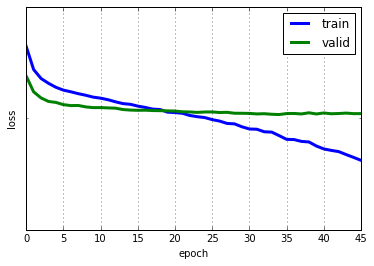

In [15]:
# visualize the training progress
%pylab inline
import matplotlib.pyplot as plt

#train_loss = np.array([i["train_loss"] for i in net.train_history_])
#valid_loss = np.array([i["valid_loss"] for i in net.train_history_])
train_loss = results[-1].evalRes.TrainLoss
valid_loss = results[-1].evalRes.ValidLoss

marginFactor = 1.2
train_min = min(train_loss)
train_max = max(train_loss)
valid_min = min(valid_loss)
valid_max = max(valid_loss)
y_min = min(train_min, valid_min)
y_max = min(train_max, valid_max)

plt.plot(train_loss, linewidth=3, label="train")
plt.plot(valid_loss, linewidth=3, label="valid")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim(y_min * 1/marginFactor, y_max * marginFactor)
plt.yscale("log")
plt.show()

INFO:root:start loading the model
INFO:gensim.utils:loading Doc2Vec object from /home/user/projekte/econstorModelling/cache/allDocs100D.model
INFO:gensim.utils:loading docvecs recursively from /home/user/projekte/econstorModelling/cache/allDocs100D.model.docvecs.* with mmap=None
INFO:gensim.utils:loading syn0 from /home/user/projekte/econstorModelling/cache/allDocs100D.model.syn0.npy with mmap=None
INFO:gensim.utils:loading syn1 from /home/user/projekte/econstorModelling/cache/allDocs100D.model.syn1.npy with mmap=None
INFO:gensim.utils:setting ignored attribute syn0norm to None
INFO:gensim.utils:setting ignored attribute cum_table to None
INFO:root:loading completed
INFO:root:building corpus...
INFO:root:corpus complete


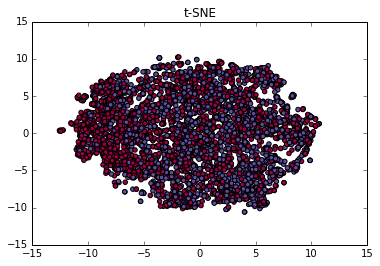

In [26]:
from sklearn import manifold

X, y = loadXy(inputDim=100, regression=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=42)
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)

try:
    x
except NameError:
    x = tsne.fit_transform(X_test)
    
plt.scatter(x[:, 0], x[:, 1], c=y_test, cmap=plt.cm.Spectral)
plt.title("t-SNE")

plt.show()

In [ ]:
# more t-sne
from loadCorpus import loadModel, loadCorpus
model = loadModel(dim=600)

%pylab inline
import matplotlib.pyplot as plt
from numpy.linalg import norm

tsneIfo = tsneDocs[:len(ifoPresidents), :]
tsneSamples = tsneDocs[len(ifoPresidents):, :]

plt.figure(figsize=(15, 12), dpi=100)
plt.scatter(tsneIfo[:, 0], tsneIfo[:, 1], s=250, c=ifoPresidentsColors, alpha=.8, cmap=plt.cm.Spectral)
plt.scatter(tsneSamples[:, 0], tsneSamples[:, 1], s=50, c='black', alpha=.05, cmap=plt.cm.Spectral)
plt.title("t-SNE")

plt.show()